In [1]:
import os
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dask_ml.preprocessing import DummyEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Data Loading and Preparation

In [14]:
# путь до данных на компьютере

path = 'data/'

In [6]:
# посмотрим структуру датасета на примере одного из файлов с признаками

df = pd.read_parquet('data/train_data_0.pq')
df.head()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [7]:
df.columns

Index(['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_total_overdue',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_4', 'enc_paym_5', 'enc_paym_6', 'enc_paym_7',
       'enc_paym_8', 'enc_paym_9', 'enc_paym_10', 'enc_paym_11', 'enc_paym_12',
       'enc_paym_13', 'enc_paym_14', 'enc_paym_15', 'enc_paym_16',
       'enc_paym_17', 'enc_paym_18', 'enc_paym_19', 'enc_paym_20',
       'enc_paym_21', 

In [9]:
df.describe()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
count,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,...,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06,1.974724e+06
mean,1.259465e+05,6.537471e+00,9.271325e+00,8.330264e+00,8.299071e+00,8.309444e+00,6.991781e+00,8.337011e+00,9.740888e+00,2.399848e+00,...,2.313242e+00,2.343014e+00,2.376717e+00,3.576724e+00,1.027562e+00,2.694898e+00,3.353936e+00,1.002386e+00,1.721385e-01,2.239336e-01
std,7.226981e+04,5.121167e+00,5.773757e+00,4.593511e+00,5.245598e+00,4.464844e+00,5.184165e+00,4.233992e+00,5.799625e+00,1.376391e+00,...,1.247674e+00,1.228473e+00,1.205555e+00,1.035586e+00,2.767022e-01,4.891363e-01,1.057304e+00,5.909327e-02,3.775009e-01,4.168782e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.344100e+04,3.000000e+00,4.000000e+00,5.000000e+00,4.000000e+00,6.000000e+00,1.000000e+00,5.000000e+00,5.000000e+00,2.000000e+00,...,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,1.263750e+05,5.000000e+00,9.000000e+00,9.000000e+00,8.000000e+00,8.000000e+00,6.000000e+00,1.000000e+01,1.000000e+01,2.000000e+00,...,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,1.889970e+05,9.000000e+00,1.400000e+01,1.100000e+01,1.300000e+01,1.200000e+01,1.200000e+01,1.100000e+01,1.500000e+01,2.000000e+00,...,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,3.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,2.499990e+05,5.100000e+01,1.900000e+01,1.700000e+01,1.700000e+01,1.600000e+01,1.600000e+01,1.500000e+01,1.900000e+01,6.000000e+00,...,3.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00,6.000000e+00,5.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00


In [8]:
# матрица корреляции признаков

df.corr()

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
id,1.000000,0.016262,0.006701,0.044194,-0.004900,-0.002403,-0.004913,0.000684,-0.000789,-0.000122,...,0.005554,0.005679,0.005455,0.000517,0.002827,-0.000572,-0.007637,-0.000629,0.005220,0.008313
rn,0.016262,1.000000,-0.027768,-0.034879,-0.023820,-0.024205,0.030645,0.112218,0.009224,0.009340,...,0.114936,0.115418,0.115182,0.092510,-0.015277,-0.142929,0.087393,-0.034806,0.010819,0.095162
pre_since_opened,0.006701,-0.027768,1.000000,0.015068,-0.024842,0.013713,-0.027968,0.014664,-0.001982,0.012031,...,-0.019254,-0.021255,-0.025319,-0.022943,0.001279,-0.034377,-0.012496,0.012023,0.020115,0.019385
pre_since_confirmed,0.044194,-0.034879,0.015068,1.000000,-0.001658,0.020560,0.043426,-0.137116,-0.005424,-0.018605,...,-0.000944,-0.000048,0.000973,0.001459,-0.010111,0.070590,-0.004960,0.005224,-0.001643,-0.064586
pre_pterm,-0.004900,-0.023820,-0.024842,-0.001658,1.000000,0.041511,0.223242,-0.055189,-0.015319,-0.018136,...,0.146284,0.146669,0.147104,0.064727,-0.037348,0.122562,0.066749,0.011756,-0.373714,-0.202932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
enc_loans_credit_status,-0.000572,-0.142929,-0.034377,0.070590,0.122562,-0.001843,0.113245,-0.219679,0.010008,-0.103931,...,0.132371,0.133585,0.138234,0.102016,-0.095994,1.000000,0.111292,0.027932,-0.219906,-0.629515
enc_loans_credit_type,-0.007637,0.087393,-0.012496,-0.004960,0.066749,0.038945,0.106997,0.002569,0.082080,0.013411,...,0.082273,0.082189,0.081592,0.091962,-0.245467,0.111292,1.000000,-0.036014,-0.089216,-0.140802
enc_loans_account_cur,-0.000629,-0.034806,0.012023,0.005224,0.011756,0.021123,0.004721,-0.022723,-0.025355,-0.007226,...,-0.019793,-0.019922,-0.019987,-0.028524,0.012269,0.027932,-0.036014,1.000000,-0.015798,-0.019610
pclose_flag,0.005220,0.010819,0.020115,-0.001643,-0.373714,0.026232,-0.526948,0.186566,0.023003,0.045493,...,-0.108616,-0.111139,-0.115718,0.070441,0.050982,-0.219906,-0.089216,-0.015798,1.000000,0.504651


In [11]:
df.isna().sum()

id                         0
rn                         0
pre_since_opened           0
pre_since_confirmed        0
pre_pterm                  0
                          ..
enc_loans_credit_status    0
enc_loans_credit_type      0
enc_loans_account_cur      0
pclose_flag                0
fclose_flag                0
Length: 61, dtype: int64

Пропусков в данных нет, все признаки бинаризованы, закодированы либо являются флагами.

In [12]:
# посмотрим на значения в каждой колонке

for column in df.columns:
    print(df[column].value_counts())

id
62963     51
77107     46
72660     44
4951      43
185462    43
          ..
220126     1
97643      1
220124     1
97668      1
125000     1
Name: count, Length: 250000, dtype: int64
rn
1     250000
2     229328
3     207951
4     186175
5     165023
6     145245
7     126275
8     108898
9      93532
10     79791
11     67690
12     57149
13     48190
14     40472
15     34053
16     28294
17     23211
18     18855
19     15031
20     11934
21      9309
22      7203
23      5495
24      4127
25      3102
26      2290
27      1696
28      1254
29       910
30       668
31       489
32       358
33       248
34       162
35        97
36        70
37        49
38        27
39        20
40        16
41        10
42         8
43         7
44         3
45         2
46         2
47         1
48         1
49         1
50         1
51         1
Name: count, dtype: int64
pre_since_opened
18    159072
6     154230
13    141904
4     138266
8     133032
0     111331
7      96090
19     94237

In [16]:
# функция, которая читает num_parts_to_read партиций, преобразовывает их к единому Dask датафрейму и возвращает его
# path_to_dataset: путь до директории с партициями
# start_from: номер партиции, с которой нужно начать чтение
# columns: список колонок, которые нужно прочитать из партиции


def read_parquet_dataset_from_local(path_to_dataset: str, start_from: int = 0,
                                     num_parts_to_read: int = 2, columns=None, verbose=False) -> dd:
    
    datasets = []
    dataset_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset)
                              if filename.startswith('train_data_')])
    start_from = max(0, start_from)
    chunk_paths = dataset_paths[start_from: start_from + num_parts_to_read]

    for chunk_path in chunk_paths:
        chunk = dd.read_parquet(chunk_path, columns=columns)
        chunk = chunk.compute()
        print(f'read {chunk_path}')
        datasets.append(chunk)

    return dd.concat(datasets)

In [17]:
# список фичей для анализа данных и обучения моделей

columns = ['id', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding',
       'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate', 'pre_loans5',
       'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90',
       'is_zero_loans5', 'is_zero_loans530', 'is_zero_loans3060',
       'is_zero_loans6090', 'is_zero_loans90', 'pre_util', 'pre_over2limit',
       'pre_maxover2limit', 'is_zero_util', 'is_zero_over2limit',
       'is_zero_maxover2limit',
       'enc_loans_account_holder_type', 'enc_loans_credit_status',
       'enc_loans_credit_type', 'enc_loans_account_cur', 'pclose_flag',
       'fclose_flag']

In [18]:
# сборка датасета

data = read_parquet_dataset_from_local(path_to_dataset=path, num_parts_to_read=12, columns=columns)

read data/train_data_0.pq
read data/train_data_1.pq
read data/train_data_10.pq
read data/train_data_11.pq
read data/train_data_2.pq
read data/train_data_3.pq
read data/train_data_4.pq
read data/train_data_5.pq
read data/train_data_6.pq
read data/train_data_7.pq
read data/train_data_8.pq
read data/train_data_9.pq


In [19]:
# пример полученных данных

data.head()

,id,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,pre_maxover2limit,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,18,9,2,3,16,10,11,3,3,...,17,1,1,1,1,3,4,1,0,0
1,0,18,9,14,14,12,12,0,3,3,...,17,1,1,1,1,3,4,1,0,0
2,0,18,9,4,8,1,11,11,0,5,...,17,0,1,1,1,2,3,1,1,1
3,0,4,1,9,12,16,7,12,2,3,...,17,1,1,1,1,3,1,1,0,0
4,0,5,12,15,2,11,12,10,2,3,...,17,1,1,1,1,3,4,1,0,0


In [21]:
# кодируем фичи, не являющиеся флагами

columns_for_dummy = ['pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
    'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
    'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
    'pre_loans_outstanding', 'pre_loans_max_overdue_sum', 'pre_loans_credit_cost_rate',
    'pre_loans5', 'pre_loans530', 'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'pre_util',
    'pre_over2limit', 'pre_maxover2limit',
    'enc_loans_account_holder_type', 'enc_loans_credit_status',
    'enc_loans_credit_type', 'enc_loans_account_cur']

data = data.categorize(columns_for_dummy)
encoder = DummyEncoder() 
data = encoder.fit_transform(data)

In [4]:
# объединяем данные по id, с агрегацией по сумме

data = data.groupby('id').sum().reset_index()
data = data.compute()

In [26]:
# переводим все колонки, кроме id, в тип int8 для экономии памяти

for column in data.columns[1:]:
    data[column] = data[column].astype(np.int8)   

In [2]:
# значения целевой переменной

targets = pd.read_csv('data/train_target.csv')
targets.head()

,id,flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [4]:
# итоговый датафрейм из обработанных признаков и таргета

data_merged = pd.merge(left=data, right=targets, how='inner', on='id')

In [5]:
data_merged.shape

(3000000, 309)

In [6]:
data_merged.head()

,id,is_zero_loans5,is_zero_loans530,is_zero_loans3060,is_zero_loans6090,is_zero_loans90,is_zero_util,is_zero_over2limit,is_zero_maxover2limit,pclose_flag,...,enc_loans_credit_type_3,enc_loans_credit_type_4,enc_loans_credit_type_5,enc_loans_credit_type_6,enc_loans_credit_type_7,enc_loans_account_cur_0,enc_loans_account_cur_1,enc_loans_account_cur_2,enc_loans_account_cur_3,flag
0,0,9,10,10,10,10,6,9,9,1,...,2,7,0,0,0,0,10,0,0,0
1,1,12,10,12,12,11,10,12,11,1,...,3,8,0,0,0,0,14,0,0,0
2,2,3,2,2,2,3,1,3,2,2,...,2,1,0,0,0,0,3,0,0,0
3,3,15,15,15,15,15,8,14,14,5,...,4,9,1,0,0,0,15,0,0,0
4,4,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,1,0,0,0


In [8]:
# целевая переменная не сбалансирована

data_merged['flag'].value_counts()

flag
0    2893558
1     106442
Name: count, dtype: int64

In [7]:
data_merged.to_csv('data/train_data.csv', index=False)

### Feature Engineering

In [9]:
data = pd.read_csv('data/train_data.csv')

In [6]:
# создадим флаги, показывающие отсутствие или наличие просрочек и задолженностей

data['is_zero_loans'] = np.where((data['is_zero_loans5'] == 0) & (data['is_zero_loans530'] == 0) & (data['is_zero_loans3060'] == 0) & (data['is_zero_loans6090'] == 0) & (data['is_zero_loans90'] == 0), 0, 1)
data['is_zero_overlimit'] = np.where((data['is_zero_over2limit'] == 0) & (data['is_zero_maxover2limit'] == 0), 0, 1)

In [11]:
data.to_csv('data/train_data_updated.csv', index=False)

# Modeling

In [2]:
data = pd.read_csv('data/train_data_updated.csv')

In [3]:
data_train, data_test = train_test_split(data, stratify=data['flag'], test_size=0.3, random_state=42)

In [4]:
# балансируем датасет методом даунсэмплинга

data_min = data_train[data_train['flag'] == 1]
data_maj = data_train[data_train['flag'] == 0]

data_maj_downsample = resample(data_maj, replace=False, n_samples=len(data_min), random_state=42)

balanced_train = pd.concat([data_maj_downsample, data_min], ignore_index=True).sample(frac=1.)

In [5]:
balanced_train.shape

(149018, 311)

In [6]:
balanced_train['flag'].value_counts()

flag
1    74509
0    74509
Name: count, dtype: int64

In [6]:
X_train, y_train = balanced_train.drop(columns=['id', 'flag']), balanced_train['flag']
X_test, y_test = data_test.drop(columns=['id', 'flag']), data_test['flag']

In [10]:
# строим модели с параметрами по умолчанию

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

model_rfc = RandomForestClassifier()
model_logreg = LogisticRegression()
model_gbc = GradientBoostingClassifier()
model_cat = CatBoostClassifier(eval_metric='AUC', custom_metric='AUC:hints=skip_train~false', verbose=100)
model_xgb = XGBClassifier()
model_lgbm = LGBMClassifier()

In [9]:
# качество моделей по метрике ROC-AUC

for model in [model_rfc, model_logreg, model_gbc, model_cat, model_xgb, model_lgbm]:
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='roc_auc', n_jobs=-1, error_score='raise')
    print(f'{model}:\nScores: {scores}\nMean score: {scores.mean()}, std: {scores.std()}\n')

RandomForestClassifier():
Scores: [0.72475833 0.73118032 0.73078883 0.73062286]
Mean score: 0.7293375872873055, std: 0.0026515720727035203

LogisticRegression():
Scores: [0.72792004 0.73387206 0.7322072  0.73314245]
Mean score: 0.7317854398838339, std: 0.002308391762145384

GradientBoostingClassifier():
Scores: [0.72132698 0.73029711 0.73110264 0.73101712]
Mean score: 0.728435963443729, std: 0.004116277755335866

<catboost.core.CatBoostClassifier object at 0x0000018EA4D71760>:
Scores: [0.74739522 0.75506489 0.75462717 0.75518126]
Mean score: 0.7530671358010121, std: 0.0032811907679369963

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=No

In [11]:
# ROC-AUC лучшей модели на тестовой выборке

model_cat.fit(X_train, y_train)
preds = model_cat.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, preds))

Learning rate set to 0.087278
0:	learn: 0.6647465	total: 190ms	remaining: 3m 9s
100:	learn: 0.7401048	total: 25.9s	remaining: 3m 50s
200:	learn: 0.7567388	total: 52.8s	remaining: 3m 29s
300:	learn: 0.7668276	total: 1m 18s	remaining: 3m 2s
400:	learn: 0.7751777	total: 1m 43s	remaining: 2m 34s
500:	learn: 0.7820603	total: 2m 7s	remaining: 2m 7s
600:	learn: 0.7881854	total: 2m 33s	remaining: 1m 41s
700:	learn: 0.7937904	total: 2m 59s	remaining: 1m 16s
800:	learn: 0.7991356	total: 3m 23s	remaining: 50.6s
900:	learn: 0.8038192	total: 3m 47s	remaining: 25s
999:	learn: 0.8081507	total: 4m 11s	remaining: 0us
0.7533149040010625


In [13]:
# тюнинг CatBoostClassifier

model_cat = CatBoostClassifier(eval_metric='AUC', custom_metric='AUC:hints=skip_train~false', verbose=100)

params_cat = {'learning_rate': [0.03, 0.1, 0.3],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        'bagging_temperature': [0, 1, 10],
        'boosting_type': ['Ordered', 'Plain'],
        'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']}

random_search_cat = model_cat.randomized_search(params_cat,
                  X_train,
                  y_train,
                  cv=kf,
                  n_iter=10)

C:\Users\tatya\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


0:	learn: 0.6366905	test: 0.6364870	best: 0.6364870 (0)	total: 192ms	remaining: 3m 12s
100:	learn: 0.7532113	test: 0.7466149	best: 0.7466149 (100)	total: 30.8s	remaining: 4m 34s
200:	learn: 0.7676722	test: 0.7508933	best: 0.7509534 (199)	total: 1m 3s	remaining: 4m 10s
300:	learn: 0.7778723	test: 0.7510870	best: 0.7514317 (277)	total: 1m 35s	remaining: 3m 41s
400:	learn: 0.7858969	test: 0.7515245	best: 0.7515551 (384)	total: 2m 8s	remaining: 3m 11s
500:	learn: 0.7926144	test: 0.7516443	best: 0.7520025 (460)	total: 2m 41s	remaining: 2m 40s
600:	learn: 0.7986314	test: 0.7521010	best: 0.7521627 (591)	total: 3m 14s	remaining: 2m 9s
700:	learn: 0.8040371	test: 0.7517280	best: 0.7521627 (591)	total: 3m 46s	remaining: 1m 36s
800:	learn: 0.8090925	test: 0.7514555	best: 0.7521627 (591)	total: 4m 17s	remaining: 1m 4s
900:	learn: 0.8138938	test: 0.7513016	best: 0.7521627 (591)	total: 4m 49s	remaining: 31.9s
999:	learn: 0.8178814	test: 0.7515211	best: 0.7521627 (591)	total: 5m 22s	remaining: 0us

b

In [21]:
model_cat.get_best_score()

{'learn': {'Logloss': 0.5518859269688575, 'AUC': 0.7964976261730542}}

In [15]:
# параметры тюнингованной модели

model_cat.get_params()

{'verbose': 100,
 'custom_metric': 'AUC:hints=skip_train~false',
 'eval_metric': 'AUC',
 'grow_policy': 'Lossguide',
 'bagging_temperature': 10,
 'boosting_type': 'Plain',
 'depth': 10,
 'learning_rate': 0.03,
 'l2_leaf_reg': 3}

In [22]:
# ROC-AUC тюнингованной модели на тестовой выборке

model_cat.fit(X_train, y_train)
preds = model_cat.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, preds))

0:	learn: 0.6701283	total: 752ms	remaining: 12m 31s
100:	learn: 0.7338021	total: 1m 7s	remaining: 10m 4s
200:	learn: 0.7476583	total: 2m 15s	remaining: 8m 58s
300:	learn: 0.7547653	total: 3m 25s	remaining: 7m 56s
400:	learn: 0.7614167	total: 4m 36s	remaining: 6m 52s
500:	learn: 0.7691989	total: 5m 50s	remaining: 5m 49s
600:	learn: 0.7758776	total: 7m 5s	remaining: 4m 42s
700:	learn: 0.7818273	total: 8m 19s	remaining: 3m 32s
800:	learn: 0.7870959	total: 9m 27s	remaining: 2m 20s
900:	learn: 0.7919977	total: 10m 35s	remaining: 1m 9s
999:	learn: 0.7964976	total: 11m 50s	remaining: 0us
0.7536295090222574


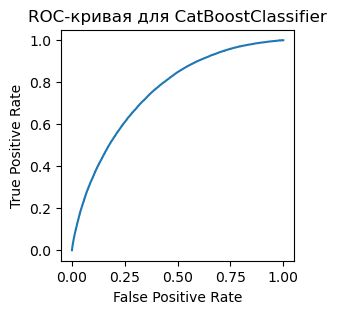

In [28]:
fpr, tpr, _ = roc_curve(y_test, preds)
plt.figure(figsize=(3, 3))
plt.plot(fpr, tpr, '-')
plt.title('ROC-кривая для CatBoostClassifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [24]:
# предсказания модели

predicts = model_cat.predict(X_test)

df_predicts = pd.DataFrame(data= {
    'id': data_test['id'],
    'flag': predicts
})

df_predicts.head()

,id,flag
1602906,1602906,0
898338,898338,1
1071279,1071279,0
1143283,1143283,1
2720285,2720285,0


In [25]:
df_predicts.to_csv('predictions.csv', index=False)

### Проверка модели на переобучение на всём датасете

In [4]:
model_cat = CatBoostClassifier(eval_metric='AUC',
                               custom_metric='AUC:hints=skip_train~false',
                               verbose=100,
                               grow_policy='Lossguide',
                               bagging_temperature=10,
                               boosting_type='Plain',
                               depth=10)

X, y = data.drop(columns=['id', 'flag']), data['flag']
scores = cross_val_score(model_cat, X, y, cv=5, scoring='roc_auc', n_jobs=-1, error_score='raise')
print(f'Scores: {scores}\nMean score: {scores.mean()}, std: {scores.std()}\n')

Scores: [0.76206513 0.75761738 0.74945444 0.7437255  0.72041155]
Mean score: 0.7466548030213996, std: 0.014579323391634156



Стандартное отклонение небольшое, переобучения нет.